This notebook is for understanding whether the weird fit behavior happens with LCEMGP
as well.

In [1]:
import math
from copy import deepcopy
from time import time
from typing import List, Optional, Callable, Any

import numpy as np
import torch
from botorch import fit_gpytorch_model
from botorch.fit import _set_transformed_inputs
from botorch.models import SingleTaskGP
from botorch.models.contextual_multioutput import LCEMGP
from botorch.models.transforms import Standardize
from botorch.optim.fit import fit_gpytorch_scipy
from botorch.optim.utils import sample_all_priors
from gpytorch import ExactMarginalLogLikelihood
from gpytorch.mlls import MarginalLogLikelihood
from torch import Tensor

%matplotlib inline
import matplotlib.pyplot as plt


def estimate_lcemgp_pcs(
    model: LCEMGP,
    context_set: Tensor,
    # If not using SAA, number of contexts may need to be passed instead
    num_samples: int,
    base_samples: Optional[Tensor],
    # base_samples could be replaced with an MCSampler
    func_I: Callable[[Tensor], Tensor],
    rho: Callable[[Tensor], Tensor],
) -> Tensor:
    r"""
    `estimate_current_generalized_pcs` modified to work with LCEMGP.
    """
    # generate the posterior and draw posterior samples
    posterior = model.posterior(context_set)
    # y_samples is `num_samples x num_contexts x num_arms`
    y_samples = posterior.rsample(
        sample_shape=torch.Size([num_samples]), base_samples=base_samples
    )
    # means is num_contexts x num_arms
    means = posterior.mean

    # Bringing them to the shapes expected in the original version
    y_samples = y_samples.permute(0, 2, 1).unsqueeze(-1)
    means = means.t().unsqueeze(-1)

    # order means across arms and apply the same ordering to y_samples
    means, indices = means.sort(dim=-3, descending=True)
    y_samples = y_samples.gather(
        dim=-3, index=indices.expand(num_samples, *indices.shape)
    )

    # calculate deltas = y_{(1)} - \max_{j!=1} y_{(j)}, actual idx is 0 here
    max_rest, _ = y_samples[..., 1:, :, :].max(dim=-3)
    deltas = y_samples[..., 0, :, :] - max_rest
    # use deltas with func_I to get samples of PCS(c)
    I_vals = func_I(deltas)
    # averaging over samples to get the estimate of PCS(c)
    pcs_c_est = I_vals.mean(dim=0)
    # feeding through rho to get estimates \hat{\rho}[PCS(c); GP_f^i]
    rho_vals = rho(pcs_c_est)
    # return with the last dimension squeezed, i.e., output is a scalar tensor.
    return rho_vals.squeeze(-1)


class GroundTruthModel:
    def __init__(
        self,
        num_arms: int,
        context_map: Tensor,
        num_init_samples: int = None,
        init_scale: float = 50.0,
        observation_noise: float = 3.0,
    ):
        r"""
        Generate a GP model for use as the ground truth for function evaluations.
        The dimension is inferred from context_map, as context_map.shape[-1] + 1.
        """
        self.num_arms = num_arms
        self.arm_map = torch.linspace(0, 1, num_arms).view(-1, 1).to(context_map)
        self.context_map = context_map
        self.dim = context_map.shape[-1] + 1
        num_init_samples = num_init_samples or self.dim * 10
        train_X = torch.rand(num_init_samples, self.dim).to(context_map)
        train_Y = torch.randn(num_init_samples, 1).to(context_map) * init_scale
        self.model = SingleTaskGP(train_X, train_Y, outcome_transform=Standardize(m=1))
        self.observation_noise = observation_noise

    def evaluate_all_true(self):
        r"""
        Evaluates all arm-context pairs without noise.
        """
        X = torch.cat(
            [
                self.arm_map.view(-1, 1, 1).repeat(1, self.context_map.shape[0], 1),
                self.context_map.repeat(self.num_arms, 1, 1),
            ],
            dim=-1,
        ).view(-1, self.dim)
        return self.model.posterior(X).mean.view(-1, 1).detach()

    def evaluate_all(self):
        true_evals = self.evaluate_all_true()
        return true_evals + torch.randn_like(true_evals) * self.observation_noise


def main(
    iterations: int,
    seed: int,
    num_pcs_samples: int = 256,
    num_arms: int = 10,
    num_contexts: int = 10,
    context_dim: int = 1,
    num_full_train: int = 3,
    ground_truth_kwargs: dict = None,
    dtype: torch.dtype = torch.double,
    device: str = "cpu",
) -> dict:
    global labels, num_labels
    torch.manual_seed(seed)
    np.random.seed(seed)
    ckwargs = {"dtype": dtype, "device": device}
    context_map = torch.rand(num_contexts, context_dim, **ckwargs)
    ground_truth_kwargs = ground_truth_kwargs or dict()
    ground_truth = GroundTruthModel(num_arms, context_map, **ground_truth_kwargs)

    true_means = ground_truth.evaluate_all_true()
    arm_set = torch.arange(0, num_arms, **ckwargs).view(-1, 1)
    train_X = (
        torch.cat(
            [
                arm_set.view(-1, 1, 1).expand(-1, num_contexts, -1),
                context_map.expand(num_arms, -1, -1),
            ],
            dim=-1,
        )
        .view(-1, context_dim + 1)
        .repeat(num_full_train, 1)
    )
    train_Y = torch.cat(
        [ground_truth.evaluate_all() for _ in range(num_full_train)], dim=0
    )

    all_alternatives = train_X[: num_arms * num_contexts].clone()
    arm_context_pairs = all_alternatives.view(num_arms, num_contexts, -1)

    start = time()
    pcs_estimates = torch.zeros(iterations, **ckwargs)
    for i in range(iterations):
        if i % 10 == 0:
            print(f"Starting seed {seed}, iteration {i}, time: {time()-start}")
        model = LCEMGP(train_X, train_Y, task_feature=0)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_model(mll)

        # report current PCS estimate
        pcs_estimates[i] = estimate_lcemgp_pcs(
            model=model,
            context_set=context_map,
            num_samples=num_pcs_samples,
            base_samples=None,
            func_I=lambda X: (X > 0).to(**ckwargs),
            rho=lambda X: X.mean(dim=-2),
        )
        next_alternative = int(torch.randint(num_contexts, (1,)))
        full_observation = ground_truth.evaluate_all().view(num_arms, num_contexts, -1)
        next_observations = full_observation[:, next_alternative]
        train_X = torch.cat([train_X, arm_context_pairs[:, next_alternative]], dim=0)
        train_Y = torch.cat([train_Y, next_observations], dim=0)

    # output_dict = {
    #     "labels": labels,
    #     "train_X": train_X,
    #     "train_Y": train_Y,
    #     "true_means": true_means,
    #     "pcs_estimates": pcs_estimates,
    # }
    return pcs_estimates


fit_model = fit_gpytorch_model

# test
# main(iterations=5, seed=0, num_arms=5)


Let's plot several replications.

Starting seed 0, iteration 0, time: 2.1696090698242188e-05
Starting seed 0, iteration 10, time: 15.094577312469482
Starting seed 0, iteration 20, time: 26.61942148208618
Starting seed 0, iteration 30, time: 46.58882713317871
Starting seed 1, iteration 0, time: 2.3126602172851562e-05
Starting seed 1, iteration 10, time: 8.592712163925171
Starting seed 1, iteration 20, time: 13.328806161880493
Starting seed 1, iteration 30, time: 17.001697063446045
Starting seed 2, iteration 0, time: 2.002716064453125e-05
Starting seed 2, iteration 10, time: 12.893155097961426
Starting seed 2, iteration 20, time: 25.680187702178955
Starting seed 2, iteration 30, time: 44.63432693481445
Starting seed 3, iteration 0, time: 2.2411346435546875e-05
Starting seed 3, iteration 10, time: 2.732266664505005
Starting seed 3, iteration 20, time: 8.260438680648804
Starting seed 3, iteration 30, time: 11.81465220451355
Starting seed 4, iteration 0, time: 2.09808349609375e-05
Starting seed 4, iteration 10, time: 12.639

/home/saitcakmak/anaconda3/envs/contextual_rs/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/home/saitcakmak/anaconda3/envs/contextual_rs/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/home/saitcakmak/anaconda3/envs/contextual_rs/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/home/saitcakmak/anaconda3/envs/contextual_rs/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  w

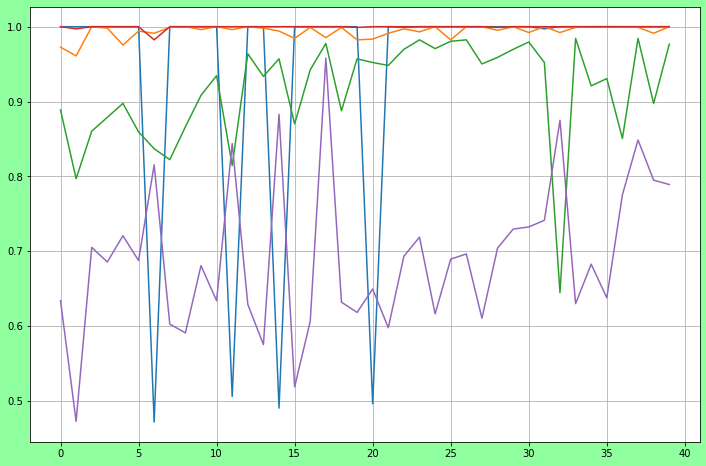

In [2]:
iterations = 40
num_arms, num_contexts = 4, 4

fig = plt.figure(figsize=(12, 8))
fig.patch.set_facecolor('xkcd:mint green')
for seed in range(5):
    plt.plot(main(iterations, seed, num_arms=num_arms, num_contexts=num_contexts))
plt.grid()
plt.show()


Try with the custom fit with `num_retries` tries.

In [4]:
def custom_fit_gpytorch_model(
    mll: MarginalLogLikelihood, optimizer: Callable = fit_gpytorch_scipy, **kwargs: Any
) -> MarginalLogLikelihood:
    r"""
    Slightly modified to work with LCEMGP as well.
    """
    mll.train()
    original_state_dict = deepcopy(mll.model.state_dict())
    retry = 0
    state_dict_list = list()
    mll_values = torch.zeros(num_retries)
    max_error_tries = kwargs.pop("max_error_tries", 10)
    randn_factor = kwargs.pop("randn_factor", 0.1)
    error_count = 0
    while retry < num_retries:
        if retry > 0:  # use normal initial conditions on first try
            mll.model.load_state_dict(original_state_dict)
            # randomize the embedding as well, reinitializing here.
            # two alternatives for initialization, specified by passing randn_factor
            for i, emb_layer in enumerate(mll.model.emb_layers):
                if randn_factor == 0:
                    new_emb = torch.nn.Embedding(
                        emb_layer.num_embeddings,
                        emb_layer.embedding_dim,
                        max_norm=emb_layer.max_norm,
                    ).to(emb_layer.weight)
                    mll.model.emb_layers[i] = new_emb
                else:
                    new_weight = torch.randn_like(emb_layer.weight) * randn_factor
                    emb_layer.weight = torch.nn.Parameter(
                        new_weight, requires_grad=True
                    )
            sample_all_priors(mll.model)
        mll, info_dict = optimizer(mll, track_iterations=False, **kwargs)
        opt_val = info_dict["fopt"]
        if math.isnan(opt_val):
            if error_count < max_error_tries:
                error_count += 1
                continue
            else:
                state_dict_list.append(original_state_dict)
                mll_values[retry] = float("-inf")
                retry += 1
                continue

        # record the fitted model and the corresponding mll value
        state_dict_list.append(deepcopy(mll.model.state_dict()))
        mll_values[retry] = -opt_val  # negate to get mll value
        retry += 1

    # pick the best among all trained models
    best_idx = mll_values.argmax()
    best_params = state_dict_list[best_idx]
    mll.model.load_state_dict(best_params)
    _set_transformed_inputs(mll=mll)
    return mll.eval()


fit_model = custom_fit_gpytorch_model

Starting seed 0, iteration 0, time: 1.7881393432617188e-05
Starting seed 0, iteration 10, time: 65.11308193206787
Starting seed 0, iteration 20, time: 142.1815984249115
Starting seed 0, iteration 30, time: 236.90601658821106
Starting seed 1, iteration 0, time: 2.0265579223632812e-05
Starting seed 1, iteration 10, time: 27.173359394073486
Starting seed 1, iteration 20, time: 60.75933480262756
Starting seed 1, iteration 30, time: 100.90086698532104
Starting seed 2, iteration 0, time: 2.0503997802734375e-05
Starting seed 2, iteration 10, time: 46.45893907546997
Starting seed 2, iteration 20, time: 101.92897772789001
Starting seed 2, iteration 30, time: 165.36051177978516
Starting seed 3, iteration 0, time: 1.4781951904296875e-05
Starting seed 3, iteration 10, time: 54.53627347946167
Starting seed 3, iteration 20, time: 128.86953377723694
Starting seed 3, iteration 30, time: 204.68922996520996
Starting seed 4, iteration 0, time: 2.2411346435546875e-05
Starting seed 4, iteration 10, time: 5

/home/saitcakmak/anaconda3/envs/contextual_rs/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


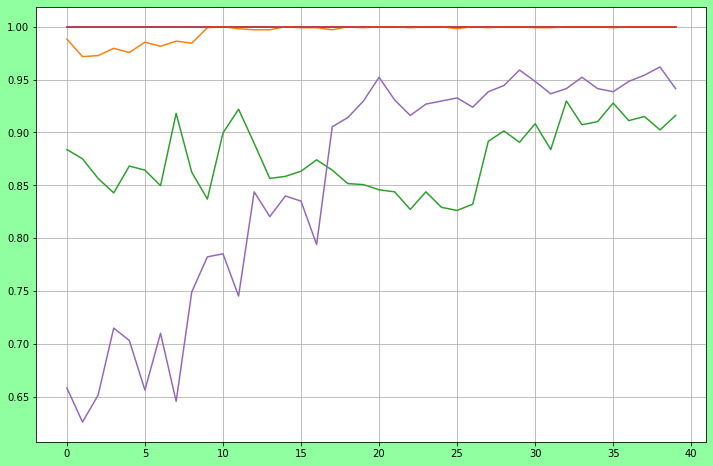

In [5]:
num_retries = 5

iterations = 40
num_arms, num_contexts = 4, 4

fig = plt.figure(figsize=(12, 8))
fig.patch.set_facecolor('xkcd:mint green')
for seed in range(5):
    plt.plot(main(iterations, seed, num_arms=num_arms, num_contexts=num_contexts))
plt.grid()
plt.show()

Starting seed 0, iteration 0, time: 1.3828277587890625e-05
Starting seed 0, iteration 10, time: 97.95222043991089
Starting seed 0, iteration 20, time: 191.04809427261353
Starting seed 0, iteration 30, time: 306.6565320491791
Starting seed 1, iteration 0, time: 1.4066696166992188e-05
Starting seed 1, iteration 10, time: 42.98348569869995
Starting seed 1, iteration 20, time: 92.70800280570984
Starting seed 1, iteration 30, time: 147.84032464027405
Starting seed 2, iteration 0, time: 1.430511474609375e-05
Starting seed 2, iteration 10, time: 67.10057520866394
Starting seed 2, iteration 20, time: 154.1244957447052
Starting seed 2, iteration 30, time: 275.5684356689453
Starting seed 3, iteration 0, time: 1.430511474609375e-05
Starting seed 3, iteration 10, time: 80.94482922554016
Starting seed 3, iteration 20, time: 164.70863842964172
Starting seed 3, iteration 30, time: 262.0274260044098
Starting seed 4, iteration 0, time: 1.3828277587890625e-05
Starting seed 4, iteration 10, time: 68.8236

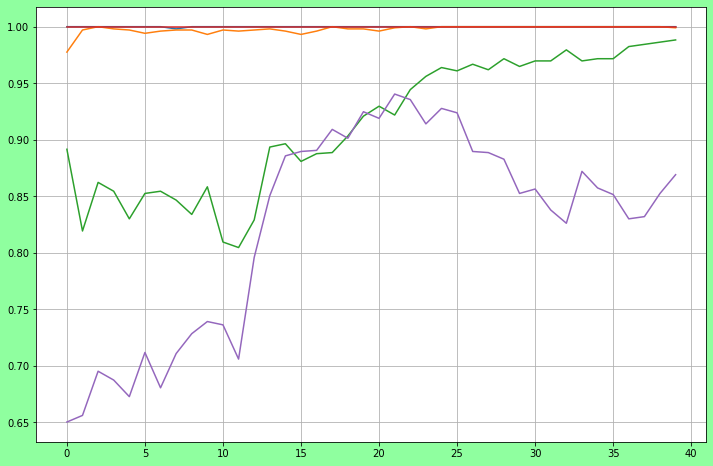

In [6]:
num_retries = 10

iterations = 40
num_arms, num_contexts = 4, 4

fig = plt.figure(figsize=(12, 8))
fig.patch.set_facecolor('xkcd:mint green')
for seed in range(5):
    plt.plot(main(iterations, seed, num_arms=num_arms, num_contexts=num_contexts))
plt.grid()
plt.show()


